# Long Short-term Cognitive Networks

In [1]:
import numpy as np
import pandas as pd

import os, random, time
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

from lstcn.LSTCN import LSTCN

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Preparing the data

In [2]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(42)
    np.random.seed(42)
    random.seed(42)

In [3]:
def load_data(df, n_steps, split=0.8):
    """ Prepare the time series for learning.

    Parameters
    ----------
    df      :   {dataframe} path to the CSV (variables must appear by column)
    n_steps :   {int} Number of steps-ahead to be forecast.
    split   :   {float} Proportion of data used for training.
    Returns
    ----------
    X_train, Y_train, X_test, Y_test, n_features

    """

    for col in df.columns:
        df[col] = 0.01 + 0.98 * (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    n_features = len(df.columns)
    data = df.to_numpy()

    # splitting the data to create the datasets
    data_train = data[:(int(split * data.shape[0])) + n_steps, :]
    data_test = data[-int((1 - split) * data.shape[0]):, :]

    # creating X_train, Y_train, X_test, Y_test
    X_train, Y_train = create_dataset(data_train, n_features, n_steps)
    X_test, Y_test = create_dataset(data_test, n_features, n_steps)

    return data_train, X_train, Y_train, X_test, Y_test, n_features


def create_dataset(data, n_features, n_steps):
    """ Create X and Y from a portion of the time series.

    Parameters
    ----------
    data         :   {array-like} Portion of the time series.
    n_features   :   {int} Number of features in the time series. 
    n_steps      :   {int} Number of steps-ahead to be forecast.
    Returns
    ----------
    X_train, Y_train or X_test, Y_test

    """

    X_data = []
    Y_data = []

    for index in range(0, data.shape[0] - (2 * n_steps - 1)):
        # the moving windows is set to one
        X_data.append(data[index:(index + n_steps), :])
        Y_data.append(data[(index + n_steps):(index + 2 * n_steps), :])

    # reshape data into 2D-NumPy arrays
    X = np.reshape(np.array(X_data), (len(X_data), n_steps * n_features))
    Y = np.reshape(np.array(Y_data), (len(Y_data), n_steps * n_features))

    return X, Y

# Performing grid-search

In [4]:
df = pd.read_csv('data' + os.sep + 'ETTh1.csv')
df.drop(labels=df.columns[0], axis='columns', inplace=True)

n_steps = 1
data, X_train, Y_train, X_test, Y_test, n_features = load_data(df, n_steps)

param_search = {
    'alpha': [1.0E-4, 1.0E-2, 1.0, 1.0E+2, 1.0E+4],
    'n_blocks': range(2, 6)
}


def one_step_scorer(Y_true, Y_pred):
    return mean_absolute_error(Y_true[:, -1], Y_pred[:, -1])


reset_random_seeds()
tscv = TimeSeriesSplit(n_splits=5)
model = LSTCN(n_features, n_steps)

start = time.time()
scorer = make_scorer(model.score, greater_is_better=False)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, refit=True,
                       n_jobs=-1, error_score='raise', scoring=scorer)

gsearch.fit(X_train, Y_train)
best_model = gsearch.best_estimator_
end = time.time()

Y_pred = best_model.predict(X_test)
train_error = round(one_step_scorer(best_model.predict(X_train), Y_train), 4)
test_error = round(one_step_scorer(Y_pred, Y_test), 4)

print(str(train_error) + ',' + str(test_error) + ',' + str(round(end - start, 4)))

0.0355,0.0192,5.4151


(3482, 7)


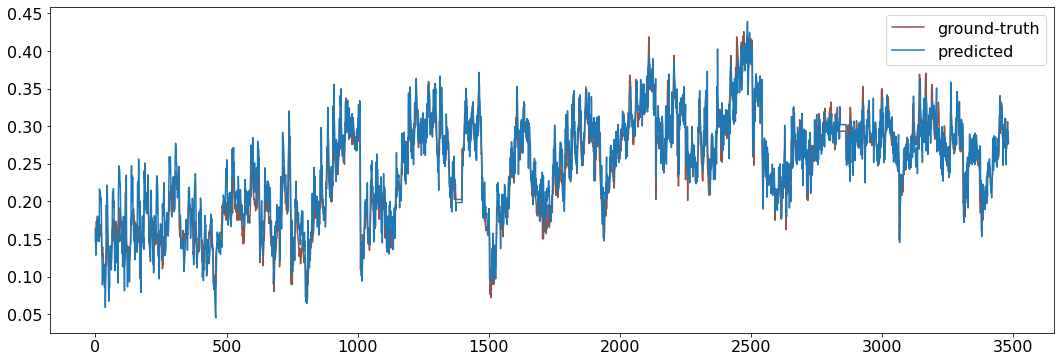

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'

print(Y_test.shape)
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(Y_test[:, -1], label='ground-truth', color='tab:brown')
plt.plot(Y_pred[:, -1], label='predicted', color='tab:blue')

leg = ax.legend(loc='upper right')
plt.show()
plt.savefig('example_pred.png')
plt.close()